In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
from SuchTree import SuchTree, SuchLinkedTrees, pearson
from scipy.stats import skew, entropy, gaussian_kde, kurtosis
import pandas as pd
import seaborn
import json
import pyprind

In [3]:
studies = json.load( open( 'data/studies.json' ) )

def load_study( study ) :
    T1  = SuchTree( study['host'] )
    T2  = SuchTree( study['guest'] )
    links = pd.DataFrame.from_csv( study['links'] )
    links = links.loc[ T1.leafs.keys() ]
    links = links[ T2.leafs.keys() ]
    return SuchLinkedTrees( T1, T2, links )

In [4]:
p = pyprind.ProgBar( len(studies), title='building graph Laplacians...' )

lps = []
for study in studies :
    SLT = load_study( study )
    lps.append( SLT.laplacian() )
    p.update()

building graph Laplacians...
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:05


In [5]:
p = pyprind.ProgBar( len(studies), title='calculating eigenvalues...' )
egs = []
for lp in lps :
    egs.append( real( eigvals( lp ) ) )
    p.update()

calculating eigenvalues...
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:01:02


In [6]:
p = pyprind.ProgBar( len(studies), title='calculating spectra...' )

bandwidth = 0.2

spectra = []
for eg in egs :
    spectra.append( gaussian_kde( eg / max(eg), bw_method=bandwidth ).pdf( linspace( -0.5,1.5,200) ) )
    p.update()

calculating spectra...
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:00


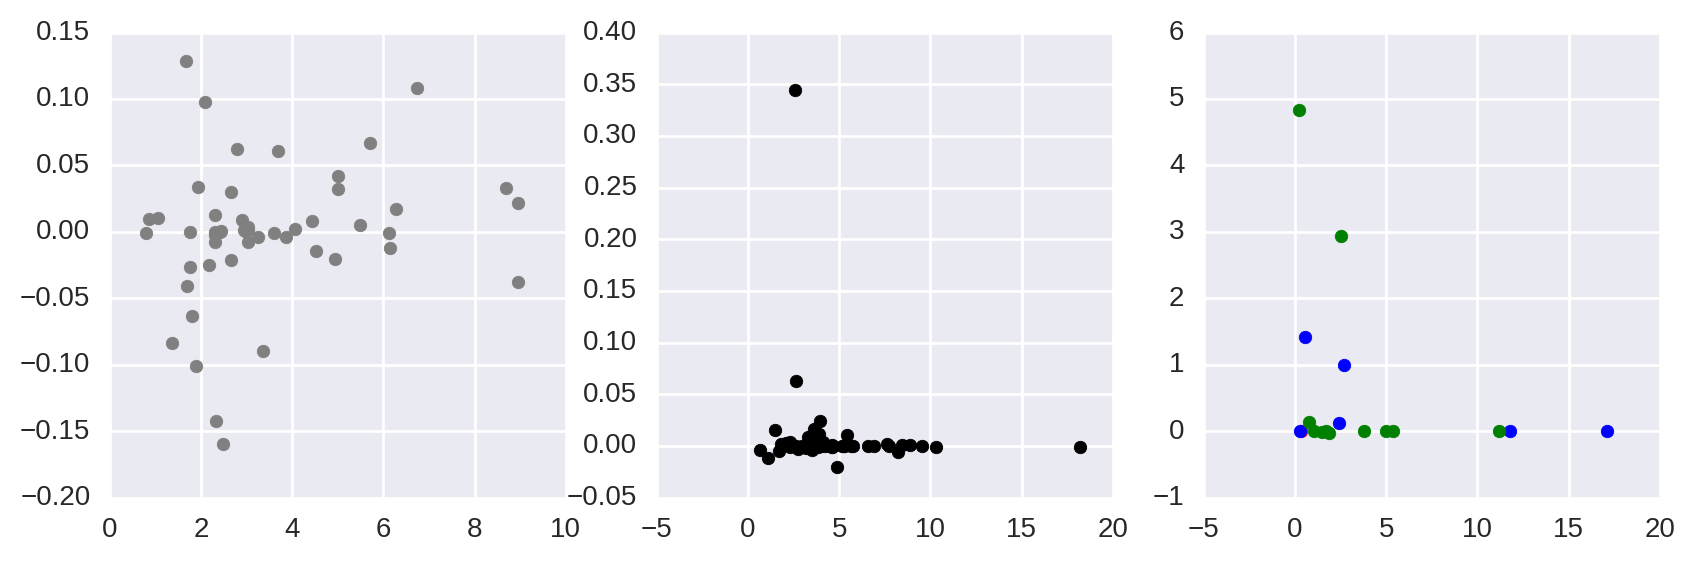

In [7]:
figure(figsize=(10,3))

typecolor = { 'null'        : 'gray', 
              'perfect'     : 'black',
              'parasitism'  : 'red',
              'frugivory'   : 'green',
              'pollination' : 'blue' }

for i,g in enumerate([ ['null'], ['perfect'], ['parasitism', 'frugivory', 'pollination' ] ]) :
    subplot(1,3,i+1)
    for study,eg,s in zip( studies, egs, spectra ) :
        if not study['type'] in g : continue
        #plot( s, color=typecolor[study['type']], lw=0.5 )
        scatter(  kurtosis( s ), eg[-1]-eg[-2], color=typecolor[study['type']]  )

In [8]:
def pdd( a, b ) :
    return ( 0.5 * entropy( a, b ) + 0.5 * entropy( b, a ) )**(0.5)

distances = zeros( ( len(spectra), len(spectra) ) )

for i,I in enumerate(spectra) :
    for j,J in enumerate(spectra) :
        if i == j : continue
        distances[i,j] = e**pdd( I, J )

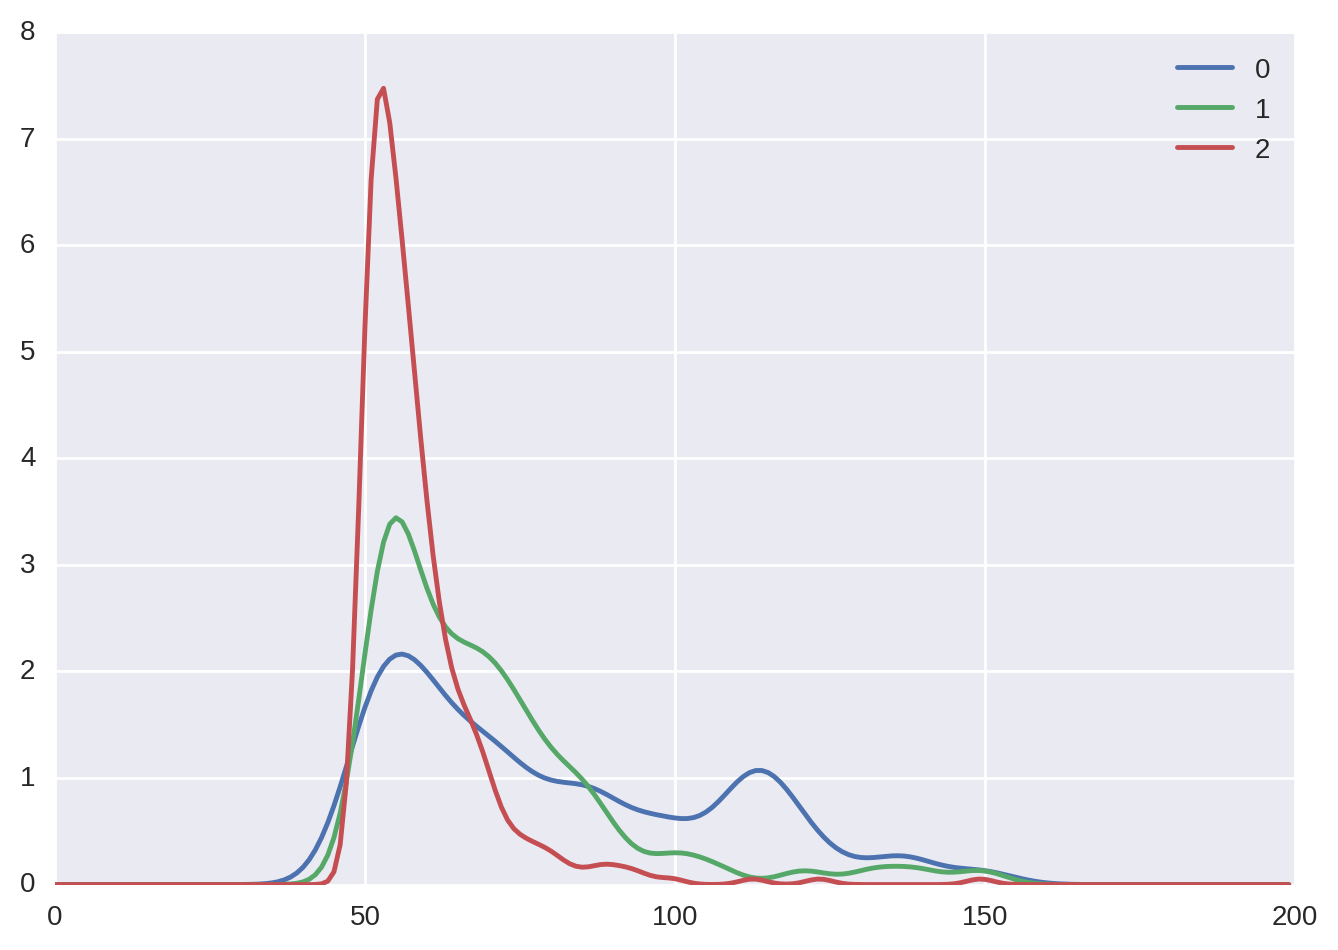

In [9]:
plot( spectra[0], label=0 )
plot( spectra[1], label=1 )
plot( spectra[2], label=2 )
legend()

In [10]:
pdd( spectra[0], spectra[2] )

1.0512707099046301

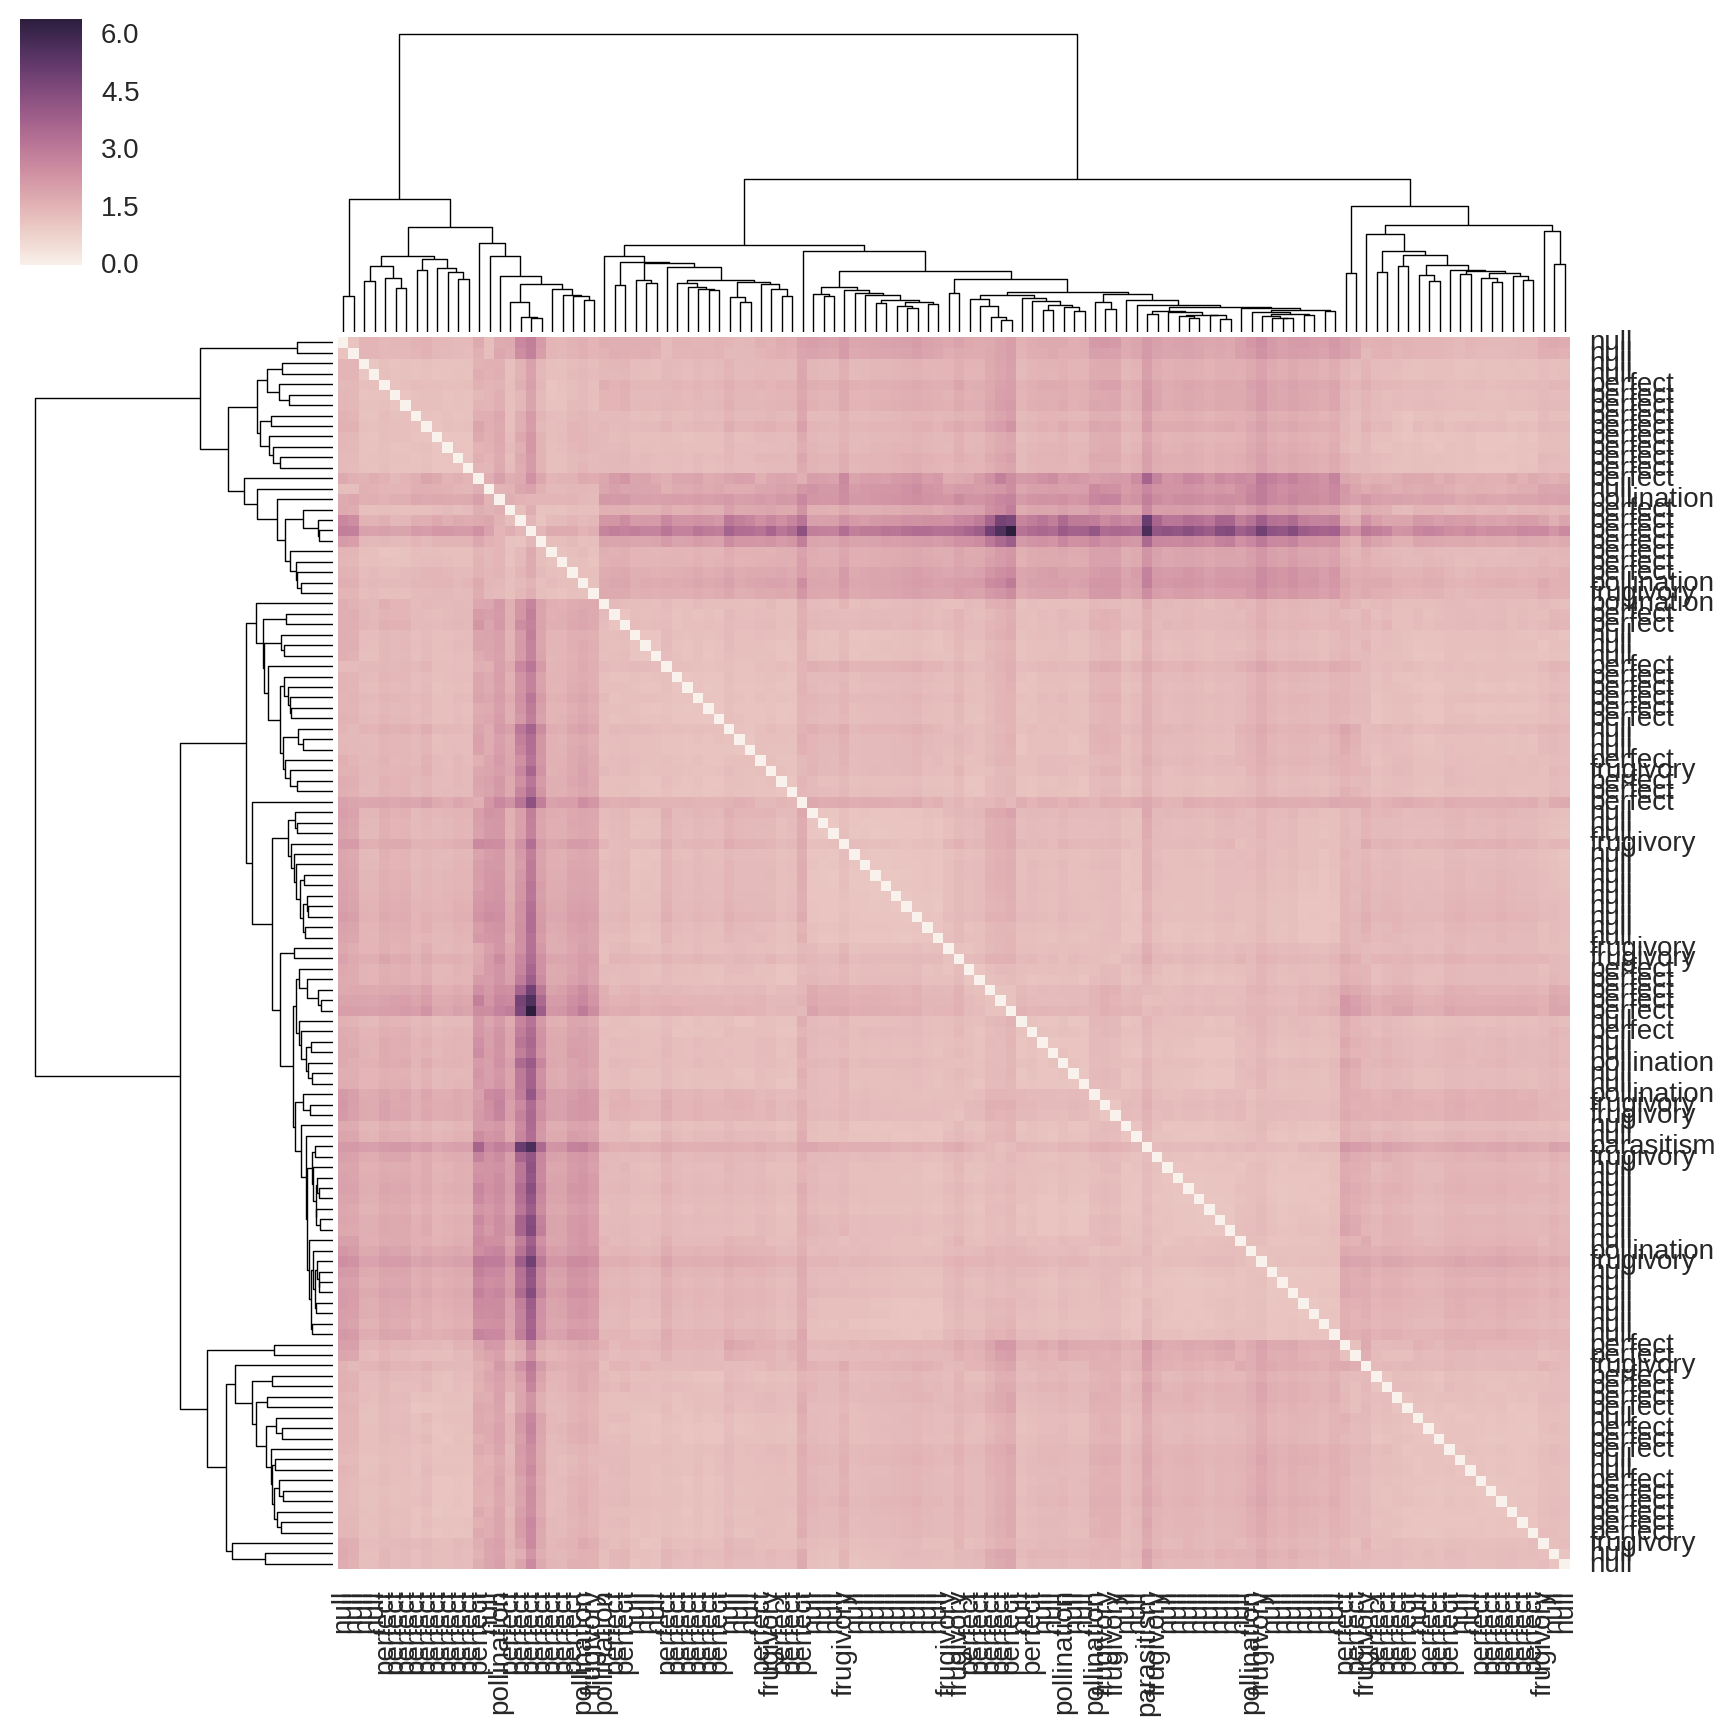

In [12]:
studytypes = map( lambda x : x['type'], studies )
cm = seaborn.clustermap( distances, xticklabels=studytypes, yticklabels=studytypes, metric="correlation" )
ticks = setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

In [31]:
N = 100
M = 5
p = pyprind.ProgBar( N*M, title='calculating spectral distances...' )

SLT = load_study( studies[1] )

a = real( eigvals( SLT.laplacian() ) )
A = gaussian_kde( a / max(a), bw_method=0.2 ).pdf( linspace( -0.5,1.5,200) )

s,d = [],[]

for i in xrange( N ) :
    for j in xrange( M ) :
        b = real( eigvals( SLT.laplacian( swaps=i ) ) )
        B = gaussian_kde( b / max(b), bw_method=0.2 ).pdf( linspace( -0.5,1.5,200) )
        s.append( i ) 
        d.append( pdd( A, B ) )
        p.update()

calculating spectral distances...
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:04


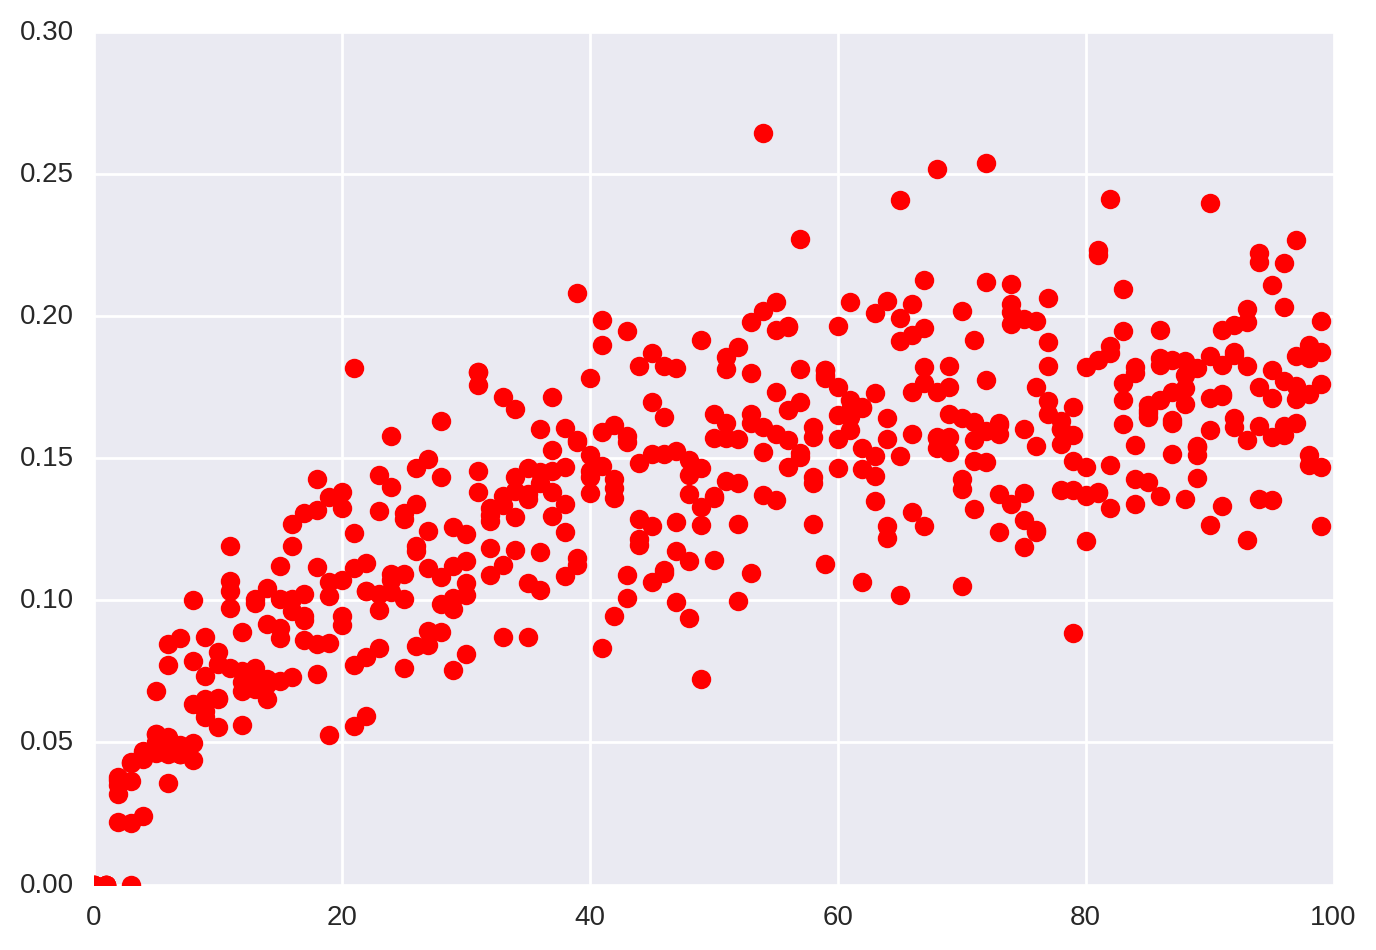

In [32]:
plot(s,d,'ro')